In [1]:
import os 
import pandas as pd
import numpy as np
import subprocess
import glob
import pybedtools as pbt 
from IPython.display import HTML
pd.set_option('display.max_rows', 200) 
pd.set_option('display.max_columns', None)
import upsetplot

import seaborn as sns 
import matplotlib.pyplot as plt 

pbt.set_bedtools_path('<path-to-bedtools-bin>')
os.chdir('<project-dir>')

gsizes = 'results/refs/hg19/hg19.chrom.sizes'
res = 5000

# make the directory to save our data
outdir = 'results/main/finemapping/sgl_intersect/'
os.makedirs(outdir, exist_ok=True)
bedpe_cols = ['chrA', 'startA', 'endA', 'chrB', 'startB', 'endB']

## Load Fine Mapped GWAS

In [2]:
# listing the main GWAS studies that will be used from now on 
major_gwas = ['T1D_32005708', 'T1D_34594039_GCST90018925', 'T1D_34012112_Gaulton']

gwas_glob = 'results/main/finemapping/*/GRCh37/offset_1000000/Summary/sss/FINAL_top_snp_credible_set.txt'
gwas_glob = glob.glob(gwas_glob)
data = []
for fn in gwas_glob:
    
    # get meta data from the path
    path_info = fn.split('/')
    
    if path_info[3] not in major_gwas:
        print('skipped: {}'.format(path_info[3]))
        continue
    
    # get the bin coordinates
    df = pd.read_table(fn)
    df.loc[:, 'bin_start'] = np.floor(df.loc[:, 'position'] / res).astype(int) * res
    df.loc[:, 'bin_end'] = df.loc[:, 'bin_start'] + res
    df = df.loc[(df.allele1.str.len() == 1 ) & (df.allele2.str.len() == 1)]
    df.loc[:, 'gwas_source'] = path_info[3]
    data.append(df)

gwas_df = pd.concat(data)

In [3]:
# filter for PIP > 0.05
gwas_df = gwas_df.loc[gwas_df.prob > 0.05]

In [4]:
gwas_df.head()

,regionID,GWASLoci,index,rsid,chromosome,position,allele1,allele2,maf,beta,se,z,prob,log10bf,mean,sd,mean_incl,sd_incl,pval,bin_start,bin_end,gwas_source
0,1,chr1:113310083-115099755,2336,1:114089649,1,114089649,A,G,0.016251,-0.1324,0.0749,-1.767690,1.0,13.5586,0.001264,0.000008,0.001264,0.000008,9.614436e-01,114085000,114090000,T1D_34594039_GCST90018925
1,1,chr1:113310083-115099755,2829,1:114270326,1,114270326,A,C,0.260388,-0.1634,0.0209,-7.818180,1.0,13.5586,0.001264,0.000008,0.001264,0.000008,1.000000e+00,114270000,114275000,T1D_34594039_GCST90018925
2,1,chr1:113310083-115099755,5046,1:114909703,1,114909703,T,C,0.131631,-0.0046,0.0261,-0.176245,1.0,13.5586,0.001264,0.000008,0.001264,0.000008,5.699493e-01,114905000,114910000,T1D_34594039_GCST90018925
3,1,chr1:113310083-115099755,3035,1:114377568,1,114377568,G,A,0.114168,-0.4287,0.0286,-14.989500,1.0,13.5586,0.001264,0.000008,0.001264,0.000008,1.000000e+00,114375000,114380000,T1D_34594039_GCST90018925
4,1,chr1:113310083-115099755,3131,1:114420328,1,114420328,T,C,0.325922,0.1320,0.0189,6.984130,1.0,13.5586,0.001264,0.000008,0.001264,0.000008,1.433164e-12,114420000,114425000,T1D_34594039_GCST90018925


In [5]:
# filter for all highly significant SNPs only
# gwas_df = gwas_df.loc[gwas_df.pval <= 5*10**(-8)]

In [6]:
# create a pybedtools for finemap data
gwas_bed = gwas_df.loc[:, ['chromosome','bin_start','bin_end', 'position', 'gwas_source']]
gwas_pbt = pbt.BedTool.from_dataframe(gwas_bed)

In [7]:
gwas_bed.head()

,chromosome,bin_start,bin_end,position,gwas_source
0,1,114085000,114090000,114089649,T1D_34594039_GCST90018925
1,1,114270000,114275000,114270326,T1D_34594039_GCST90018925
2,1,114905000,114910000,114909703,T1D_34594039_GCST90018925
3,1,114375000,114380000,114377568,T1D_34594039_GCST90018925
4,1,114420000,114425000,114420328,T1D_34594039_GCST90018925


## Load HiChIP Loops

In [8]:
def parse_seB(x): 
    s,e = x.split(':')[1].split('-')
    e = e.split(',')[0]
    return((s,e))

In [9]:
loops = 'results/main/2021_Nikhil_eQTL/Data/FitHiChIP_Loops/'
loops += '*/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01_WashU.bed.gz'
loops = glob.glob(loops)

# only analyze loop data from main cell types 
loops = ['results/main/2021_Nikhil_eQTL/Data/FitHiChIP_Loops/CD4N/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01_WashU.bed.gz',
 'results/main/2021_Nikhil_eQTL/Data/FitHiChIP_Loops/CD8N/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01_WashU.bed.gz',
 'results/main/2021_Nikhil_eQTL/Data/FitHiChIP_Loops/NB/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01_WashU.bed.gz',
 'results/main/2021_Nikhil_eQTL/Data/FitHiChIP_Loops/CM/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01_WashU.bed.gz',
 'results/main/2021_Nikhil_eQTL/Data/FitHiChIP_Loops/NK/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01_WashU.bed.gz']

In [10]:
loop_data = []
for loop in loops:
    print(loop)
    
    # extract cell line
    cline = loop.split('/')[5]
    
    # load and parse the data
    df = pd.read_table(loop, header=None)    
    df.columns = ['chrom', 'startA', 'endA', 'seB', 'e1', 'e2']
    df['chrom'] = df['chrom'].str.replace('chr', '')
    df['startB'], df['endB'] = zip(*df['seB'].apply(parse_seB))
    df['startB'] = df['startB'].astype(int)
    df['startA'] = df['startA'] + 1 - int(res / 2)
    df['endA'] = df['startA'] + res
    df['startB'] = df['startB'] + 1 - int(res / 2)
    df['endB'] = df['startB'] + res
    
    
    # re-organize the data into bedpe-like
    df = df.iloc[:, [0,1,2,0,6,7,3,4,5]]
    
    df['log10_pvalue_loop'] =  df['seB'].apply(lambda x: float(x.split(',')[-1]))


    # add cell type
    df['cline'] = cline

    loop_data.append(df) 
loop_df = pd.concat(loop_data)

results/main/2021_Nikhil_eQTL/Data/FitHiChIP_Loops/CD4N/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01_WashU.bed.gz
results/main/2021_Nikhil_eQTL/Data/FitHiChIP_Loops/CD8N/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01_WashU.bed.gz
results/main/2021_Nikhil_eQTL/Data/FitHiChIP_Loops/NB/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01_WashU.bed.gz
results/main/2021_Nikhil_eQTL/Data/FitHiChIP_Loops/CM/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01_WashU.bed.gz
results/main/2021_Nikhil_eQTL/Data/FitHiChIP_Loops/NK/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01_WashU.bed.gz


In [11]:
# create a dataframe in bed format which filters for significant
# SNPs only p-val < 0.05 (or -log10(p-val) > 1.3)
loop_bed = loop_df.loc[loop_df.log10_pvalue_loop > 1.3].iloc[:, [0,1,2,3,4,5,-1]]

# create a pybedtools for the looping data
loop_pbt = pbt.BedTool.from_dataframe(loop_bed)

In [12]:
loop_bed.head()

,chrom,startA,endA,chrom,startB,endB,cline
0,1,710000,715000,1,1305000,1310000,CD4N
1,1,710000,715000,1,755000,760000,CD4N
2,1,710000,715000,1,760000,765000,CD4N
3,1,710000,715000,1,775000,780000,CD4N
4,1,710000,715000,1,805000,810000,CD4N


## Intersect Fine Mapped GWAS and loops

#### Perform the intersection

In [13]:
# intersecting the GWAS SNPs with loops 
# loop anchor doesn't matter therefore type='either'
intersect_pbt = loop_pbt.pair_to_bed(gwas_pbt, type='either')

# convert the intersection into a dataframe and rename columns 
gwas_hichip = intersect_pbt.to_dataframe(header=None, disable_auto_names=True)
gwas_hichip = gwas_hichip.iloc[:, [7,8,9,10,0,1,2,3,4,5,6,11]]
loop_cols = ['{}_loop'.format(x) for x in bedpe_cols]
gwas_hichip.columns = ['chr_snp', 'bin_start', 'bin_end', 'pos'] + loop_cols + ['cline_loop', 'gwas_source']

# add back fields from the original gwas data
# some data was lost in the pybedtool process
gwas_hichip = gwas_hichip.merge(gwas_df.drop('gwas_source', axis=1),
                                left_on=['chr_snp', 'pos'],
                                right_on=['chromosome', 'position'])
# add the sid as the variant id
gwas_hichip['sid'] = 'chr' +  gwas_hichip['chr_snp'].astype(str) + ':' + gwas_hichip['position'].astype(str)

In [14]:
gwas_hichip.head()

,chr_snp,bin_start_x,bin_end_x,pos,chrA_loop,startA_loop,endA_loop,chrB_loop,startB_loop,endB_loop,cline_loop,gwas_source,regionID,GWASLoci,index,rsid,chromosome,position,allele1,allele2,maf,beta,se,z,prob,log10bf,mean,sd,mean_incl,sd_incl,pval,bin_start_y,bin_end_y,sid
0,1,35905000,35910000,35908451,1,35905000,35910000,1,36020000,36025000,CD4N,T1D_32005708,2,chr1:35880971-36880971,1508,1:35908451,1,35908451,C,T,0.0269,0.2724,0.0665,4.09624,0.087114,1.98206,0.018319,0.076063,0.210282,0.161391,0.000021,35905000,35910000,chr1:35908451
1,1,35905000,35910000,35908451,1,35655000,35660000,1,35905000,35910000,CD8N,T1D_32005708,2,chr1:35880971-36880971,1508,1:35908451,1,35908451,C,T,0.0269,0.2724,0.0665,4.09624,0.087114,1.98206,0.018319,0.076063,0.210282,0.161391,0.000021,35905000,35910000,chr1:35908451
2,1,35905000,35910000,35908451,1,35905000,35910000,1,36020000,36025000,CD8N,T1D_32005708,2,chr1:35880971-36880971,1508,1:35908451,1,35908451,C,T,0.0269,0.2724,0.0665,4.09624,0.087114,1.98206,0.018319,0.076063,0.210282,0.161391,0.000021,35905000,35910000,chr1:35908451
3,1,63785000,63790000,63787316,1,63785000,63790000,1,65530000,65535000,CD4N,T1D_32005708,4,chr1:63606817-64608682,1568,1:63787316,1,63787316,T,C,0.0065,0.6030,0.1469,4.10483,0.310873,2.90943,0.085952,0.182577,0.276485,0.233557,0.000020,63785000,63790000,chr1:63787316
4,1,63785000,63790000,63787316,1,63785000,63790000,1,63925000,63930000,CM,T1D_32005708,4,chr1:63606817-64608682,1568,1:63787316,1,63787316,T,C,0.0065,0.6030,0.1469,4.10483,0.310873,2.90943,0.085952,0.182577,0.276485,0.233557,0.000020,63785000,63790000,chr1:63787316


#### Add loop ids which are used for unique set analysis downstream

In [15]:
def make_lid(sr, cols):
    lid = sr[cols].tolist()
    lid = [str(x) for x in lid]
    lid = ':'.join(lid)
    return(lid)
lid_cols = [2,3,4,5,6,7]
lids = []
for sr in gwas_hichip.values: 
    new_lid = make_lid(sr, lid_cols)
    lids.append(new_lid)
gwas_hichip['loop_id'] = lids

In [16]:
gwas_hichip.head()

,chr_snp,bin_start_x,bin_end_x,pos,chrA_loop,startA_loop,endA_loop,chrB_loop,startB_loop,endB_loop,cline_loop,gwas_source,regionID,GWASLoci,index,rsid,chromosome,position,allele1,allele2,maf,beta,se,z,prob,log10bf,mean,sd,mean_incl,sd_incl,pval,bin_start_y,bin_end_y,sid,loop_id
0,1,35905000,35910000,35908451,1,35905000,35910000,1,36020000,36025000,CD4N,T1D_32005708,2,chr1:35880971-36880971,1508,1:35908451,1,35908451,C,T,0.0269,0.2724,0.0665,4.09624,0.087114,1.98206,0.018319,0.076063,0.210282,0.161391,0.000021,35905000,35910000,chr1:35908451,35910000:35908451:1:35905000:35910000:1
1,1,35905000,35910000,35908451,1,35655000,35660000,1,35905000,35910000,CD8N,T1D_32005708,2,chr1:35880971-36880971,1508,1:35908451,1,35908451,C,T,0.0269,0.2724,0.0665,4.09624,0.087114,1.98206,0.018319,0.076063,0.210282,0.161391,0.000021,35905000,35910000,chr1:35908451,35910000:35908451:1:35655000:35660000:1
2,1,35905000,35910000,35908451,1,35905000,35910000,1,36020000,36025000,CD8N,T1D_32005708,2,chr1:35880971-36880971,1508,1:35908451,1,35908451,C,T,0.0269,0.2724,0.0665,4.09624,0.087114,1.98206,0.018319,0.076063,0.210282,0.161391,0.000021,35905000,35910000,chr1:35908451,35910000:35908451:1:35905000:35910000:1
3,1,63785000,63790000,63787316,1,63785000,63790000,1,65530000,65535000,CD4N,T1D_32005708,4,chr1:63606817-64608682,1568,1:63787316,1,63787316,T,C,0.0065,0.6030,0.1469,4.10483,0.310873,2.90943,0.085952,0.182577,0.276485,0.233557,0.000020,63785000,63790000,chr1:63787316,63790000:63787316:1:63785000:63790000:1
4,1,63785000,63790000,63787316,1,63785000,63790000,1,63925000,63930000,CM,T1D_32005708,4,chr1:63606817-64608682,1568,1:63787316,1,63787316,T,C,0.0065,0.6030,0.1469,4.10483,0.310873,2.90943,0.085952,0.182577,0.276485,0.233557,0.000020,63785000,63790000,chr1:63787316,63790000:63787316:1:63785000:63790000:1


In [17]:
gwas_hichip.shape

(2091, 35)

## Integrate genes and located SGLs

For the types of SGLs through this approach we have to find identify loops where one anchor overlaps a SNP and the other one overlaps a gene promoter. As such, we used the previously intersected data to find loop anchors without a SNP overlap and we will intersect these anchors with gene promoters next. 

### Load the gene data and build promoter based pybedtool

In [18]:
print('# Load the gene data')

genes_fn = 'results/refs/gencode/v30/gencode.v30.annotation.bed'

# load the gencode coords
cols = ['chrom', 'start', 'end', 'strand', 'type', 'gene_id', 'gname']
gencode = pd.read_table(genes_fn, header=None, names=cols)

# extract just the genes
genes_df = gencode.loc[gencode['type'].isin(['gene'])]
genes_df = genes_df.loc[~genes_df.duplicated(subset='gene_id'), :]
genes_df.loc[:, 'chrom'] = genes_df['chrom'].astype(str)
genes_df = genes_df.iloc[:, [0,1,2,6,5,3]]

# create a copy of the original gene bed before coordinate shrinking
orig_genes_df = genes_df.copy()

# convert the start/end position into start/end for the TSS
# if the gene is + then the start is uses as the tss otherwise
# the end is used as the tss
genes_df.loc[(genes_df.strand == '+'), 'end'] = genes_df.loc[(genes_df.strand == '+'), 'start']
genes_df.loc[(genes_df.strand == '+'), 'start'] = genes_df.loc[(genes_df.strand == '+'), 'start'] - 1
genes_df.loc[(genes_df.strand == '-'), 'end'] = genes_df.loc[(genes_df.strand == '-'), 'end']
genes_df.loc[(genes_df.strand == '-'), 'start'] = genes_df.loc[(genes_df.strand == '-'), 'end'] - 1
genes_df.loc[:, 'chrom'] = genes_df.loc[:, 'chrom'].str.replace('chr', '')
genes_df.loc[:, 'bin_start'] = (np.floor(genes_df.loc[:, 'start'] / res) * res).astype(int)
genes_df.loc[:, 'bin_end'] = genes_df.loc[:, 'bin_start'] + res

# make a genes pbt for intersection
print("# make a genes pbt for intersection")
print(genes_df.head())
genes_pbt = pbt.BedTool.from_dataframe(genes_df).sort()

print('There are {} genes in this GTF-derived file.'.format(genes_df.shape[0]))

# Load the gene data
# make a genes pbt for intersection
   chrom  start    end        gname          gene_id strand  bin_start  \
0      1  11868  11869      DDX11L1  ENSG00000223972      +      10000   
12     1  29569  29570       WASH7P  ENSG00000227232      -      25000   
25     1  17435  17436    MIR6859-1  ENSG00000278267      -      15000   
28     1  29553  29554  MIR1302-2HG  ENSG00000243485      +      25000   
36     1  30365  30366    MIR1302-2  ENSG00000284332      +      30000   

    bin_end  
0     15000  
12    30000  
25    20000  
28    30000  
36    35000  
There are 58825 genes in this GTF-derived file.


### Determine which anchor the SNP falls into

In [19]:
snp_anchor = []
for i, sr in gwas_hichip.iterrows():
    if (sr.startA_loop <= sr.position) & (sr.position <= sr.endA_loop):
        snp_anchor.append('AnchorA')
    elif (sr.startB_loop <= sr.position) & (sr.position <= sr.endB_loop):
        snp_anchor.append('AnchorB')
    else:
        snp_anchor.append('bug')
        print('bug')
        break
gwas_hichip.loc[:, 'snp_anchor'] = snp_anchor

In [20]:
print('SNP anchor designation:', gwas_hichip['snp_anchor'].unique().tolist())

SNP anchor designation: ['AnchorA', 'AnchorB']


### Extract anchors opposite of a SNP anchor

In [21]:
# using a basic serial id for merging post bedtools intersection
gwas_hichip['gh_id'] = range(gwas_hichip.shape[0])

anchor_cols = ['chrB_loop', 'startB_loop', 'endB_loop', 'gh_id']
nonsnp_anchorsA = gwas_hichip.loc[gwas_hichip['snp_anchor'] == 'AnchorA', anchor_cols]
anchor_cols =  ['chrA_loop', 'startA_loop', 'endA_loop', 'gh_id']
nonsnp_anchorsB = gwas_hichip.loc[gwas_hichip['snp_anchor'] == 'AnchorB', anchor_cols]

nonsnp_anchorsA.columns = ['chr', 'start', 'end', 'gh_id']
nonsnp_anchorsB.columns = ['chr', 'start', 'end', 'gh_id']
nonsnp_anchors = pd.concat([nonsnp_anchorsA, nonsnp_anchorsB], axis=0)
nonsnp_anchors_pbt = pbt.BedTool.from_dataframe(nonsnp_anchors)

In [22]:
nonsnp_anchors.head()

,chr,start,end,gh_id
0,1,36020000,36025000,0
2,1,36020000,36025000,2
3,1,65530000,65535000,3
4,1,63925000,63930000,4
5,1,63985000,63990000,5


### Intersecting genes on anchors opposing a SNP anchor

In [23]:
gene_overlaps = nonsnp_anchors_pbt.intersect(genes_pbt, wa=True, wb=True)
gene_overlaps = gene_overlaps.to_dataframe(header=None, disable_auto_names=True)

In [24]:
print('The number of anchor gene overlaps is:', gene_overlaps.shape)

The number of anchor gene overlaps is: (353, 12)


In [25]:
gene_overlaps.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1,115640000,115645000,36,1,115641969,115641970,VANGL1,ENSG00000173218,+,115640000,115645000
1,10,7830000,7835000,119,10,7833956,7833957,AL353754.1,ENSG00000233990,-,7830000,7835000
2,10,42660000,42665000,134,10,42660727,42660728,VN1R54P,ENSG00000232109,+,42660000,42665000
3,10,42660000,42665000,141,10,42660727,42660728,VN1R54P,ENSG00000232109,+,42660000,42665000
4,10,42660000,42665000,146,10,42660727,42660728,VN1R54P,ENSG00000232109,+,42660000,42665000


### Add gene overlaps to SNP-Loop Pairs

In [26]:
gene_overlaps.columns = ['chrSNP', 'startSNP', 'endSNP', 'gh_id',
                         'chrGene', 'startGene', 'endGene',
                         'genename', 'geneid', 'strand', 'bin_start', 'bin_end']
gwas_hichip_genes = gwas_hichip.merge(gene_overlaps,
                                      on=['gh_id'],
                                      how='left')
gwas_hichip_genes = gwas_hichip_genes.loc[~gwas_hichip_genes.chrSNP.isna()]

In [70]:
print('There are {} SGLs.'.format(len(gwas_hichip_genes)))

There are 353 SGLs.


In [71]:
print('There are {} unique SNPs within an SGL'.format(gwas_hichip_genes[['rsid']].nunique()))

There are rsid    93
dtype: int64 unique SNPs within an SGL


## Summarize the SNPs, Loops and Intersection

Now that we have the SGLs I want to perform different analyses and save these results for downstream use. 

### Make a table of uniq SNPs and Genes

In [28]:
# find the unique SNPs
uniq_snps_by_cells = gwas_hichip_genes.groupby('cline_loop').sid.nunique()
uniq_snps_by_cells = uniq_snps_by_cells.to_frame()

# find the unique genes 
uniq_genes_by_cells = gwas_hichip_genes.groupby('cline_loop').geneid.nunique()
uniq_genes_by_cells = uniq_genes_by_cells.to_frame()

# merge snps and genes
uniq_counts_by_cells = pd.merge(uniq_snps_by_cells, uniq_genes_by_cells, left_index=True, right_index=True)
uniq_counts_by_cells.columns = ['Number of Unique SNPs', 'Number of Unique Genes']
uniq_counts_by_cells.index.name = 'Cell Line'

# save the file
excel_analysis = os.path.join(outdir, 'Unique_Counts_By_Cell_Line.xlsx')
uniq_counts_by_cells.to_excel(excel_analysis, sheet_name='finemapping')

In [29]:
excel_analysis

'results/main/finemapping/sgl_intersect/Unique_Counts_By_Cell_Line.xlsx'

In [30]:
print('There are {} unique SNP-gene pairs across all cell types.'.format(gwas_hichip_genes.shape[0]))

There are 353 unique SNP-gene pairs across all cell types.


### Make a figure of uniq SNPs and Genes per cell

In [31]:
# rename cells with publishing names
cline_pubnames = {'CD4N': 'CD4 T-cells', 'CD8N': 'CD8 T-cells',
                  'CM': 'Monocytes', 'NB': 'B-cells', 'NK': 'NK cells'}
uniq_counts_by_cells['pubnames'] = uniq_counts_by_cells.index.map(cline_pubnames)
uniq_counts_by_cells.sort_values('pubnames', inplace=True)

uniq_counts_by_cells

,Number of Unique SNPs,Number of Unique Genes,pubnames
Cell Line,,,
NB,33,57,B-cells
CD4N,39,62,CD4 T-cells
CD8N,27,36,CD8 T-cells
CM,30,35,Monocytes
NK,46,63,NK cells


In [32]:
# get the dictionary of DICE colors for each cell type
color_fn = 'results/refs/dice_colors/colors.revised.t1d-project.tsv'
colors = pd.read_table(color_fn)
colors_dict = {sr.studyname: sr.hex for i, sr in colors.iterrows()}

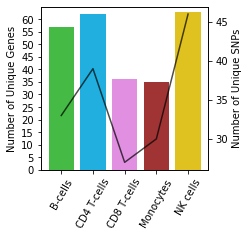

In [73]:
fig, ax = plt.subplots(figsize=(3,3))

uniq_counts_by_cells = uniq_counts_by_cells

sns.barplot(x='pubnames', y='Number of Unique Genes', palette=colors_dict, data=uniq_counts_by_cells, dodge=False)

ax.set_xlabel('')
ax.set_xticklabels(uniq_counts_by_cells['pubnames'], rotation = 60)
ax.set_ylim(0, 65)
ax.set_yticks(range(0, 65, 5))

ax2 = ax.twinx()
sns.lineplot(x='pubnames', y='Number of Unique SNPs', data=uniq_counts_by_cells, color='#000000B3', ax=ax2)
#ax2.set_ylim(0, 8)

sgl_summary_fn = os.path.join(outdir, 'sgls_finemap_with_hichip_summary.svg')
#fig.savefig(sgl_summary_fn)

### Write the gene list as well

In [34]:
gh_list = gwas_hichip_genes.geneid.unique()
gh_fn = os.path.join(outdir, 'gene_list.txt')
with open(gh_fn, 'w') as fw:
    for x in gh_list:
        fw.write('{}\n'.format(x))

### Write  unique genes per cell type 

In [35]:
genes_by_cell = gwas_hichip_genes[['cline_loop', 'geneid']].drop_duplicates()
genes_by_cell.sort_values(['cline_loop', 'geneid'], inplace=True)
genes_by_cell['source'] = 'finemap_with_hichip'
genes_by_cell.columns = ['cline', 'geneid', 'source']
fn = os.path.join(outdir, 'genes_by_cell.xlsx')
genes_by_cell.to_excel(fn, index=False)

### Summarize the Number of Loops per Cell (pre-intersection)

In [36]:
total_gwas = gwas_df.shape[0]
cell_summary = {}

In [37]:
cell_summary['total_loops'] = loop_df.groupby('cline').count()['startA'].to_frame()
cell_summary['total_loops'].columns = ['total_hichip']
cell_summary['total_loops']

,total_hichip
cline,
CD4N,114421
CD8N,84599
CM,84298
NB,128288
NK,129890


### Summarize the Number of SNP-Loop (SL) Pairs per Cell

In [38]:
cell_summary['sl_pairs'] = gwas_hichip['cline_loop'].value_counts().to_frame()
cell_summary['sl_pairs'].columns = ['sl_pairs']
cell_summary['sl_pairs']

,sl_pairs
NB,673
NK,493
CD4N,383
CM,278
CD8N,264


### Summarize the Number of Unique GWAS SNPs which Overlap a HiChIP Loop per Cell

In [39]:
cell_summary['uniq_gwas'] = gwas_hichip.groupby('cline_loop')['sid'].nunique().to_frame()
cell_summary['uniq_gwas'].columns = ['uniq_gwas_in_slpairs']
cell_summary['uniq_gwas']

,uniq_gwas_in_slpairs
cline_loop,
CD4N,82
CD8N,68
CM,72
NB,132
NK,102


### Summarize the Number of Loops with GWAS Overlaps (per cell)

In [40]:
loop_cols = ['chrA_loop', 'startA_loop', 'endA_loop', 'chrB_loop', 'startB_loop', 'endB_loop']
cell_summary['uniq_loops'] = gwas_hichip.groupby('cline_loop')['loop_id'].nunique().to_frame()
cell_summary['uniq_loops'].columns = ['uniq_loops_in_slpairs']
cell_summary['uniq_loops']

,uniq_loops_in_slpairs
cline_loop,
CD4N,272
CD8N,190
CM,212
NB,446
NK,320


### Construct a large summary table

In [41]:
concat_list = [cell_summary['total_loops'], cell_summary['sl_pairs'],
               cell_summary['uniq_gwas'], cell_summary['uniq_loops']]
summary = pd.concat(concat_list, axis=1)
summary['pct_uniq_gwas_in_slpairs'] = summary['uniq_gwas_in_slpairs'] / total_gwas * 100
summary['pct_uniq_loops_in_slpairs'] = summary['uniq_loops_in_slpairs'] / summary['total_hichip'] * 100

In [42]:
summary

,total_hichip,sl_pairs,uniq_gwas_in_slpairs,uniq_loops_in_slpairs,pct_uniq_gwas_in_slpairs,pct_uniq_loops_in_slpairs
CD4N,114421,383,82,272,13.781513,0.237719
CD8N,84599,264,68,190,11.428571,0.224589
CM,84298,278,72,212,12.100840,0.251489
NB,128288,673,132,446,22.184874,0.347655
NK,129890,493,102,320,17.142857,0.246362


In [43]:
final_summary = summary.copy()

In [44]:
final_colnames = ['Total\\nHiChIP Loops', 
                  'Number of\\nGWAS-Loop Pairs',
                  'Number of\\nUnique GWAS SNPs in GL Pairs', 
                  'Number of\\nUnique loops in GL Pairs',
                  'Percentage of\\nUnique GWAS SNPs in GL Pairs', 
                  'Percentage of\\nUnique loops in GL Pairs']
final_colnames = ['Total HiChIP Loops', 
                  'Number of GWAS-Loop Pairs',
                  'Number of Unique GWAS SNPs in GL Pairs', 
                  'Number of Unique loops in GL Pairs',
                  'Percentage of Unique GWAS SNPs in GL Pairs', 
                  'Percentage of Unique loops in GL Pairs']
final_summary.columns = final_colnames

In [45]:
display(HTML(final_summary.to_html().replace("\\n","<br>")))

,Total HiChIP Loops,Number of GWAS-Loop Pairs,Number of Unique GWAS SNPs in GL Pairs,Number of Unique loops in GL Pairs,Percentage of Unique GWAS SNPs in GL Pairs,Percentage of Unique loops in GL Pairs
CD4N,114421,383,82,272,13.781513,0.237719
CD8N,84599,264,68,190,11.428571,0.224589
CM,84298,278,72,212,12.100840,0.251489
NB,128288,673,132,446,22.184874,0.347655
NK,129890,493,102,320,17.142857,0.246362


## Save SGLs for Further Analyses

In [46]:
finemap_sgls_fn = os.path.join(outdir, 'finemap_sgls.tsv')
gwas_hichip_genes.to_csv(finemap_sgls_fn,  sep='\t', index=False)

In [47]:
gwas_hichip_genes

,chr_snp,bin_start_x,bin_end_x,pos,chrA_loop,startA_loop,endA_loop,chrB_loop,startB_loop,endB_loop,cline_loop,gwas_source,regionID,GWASLoci,index,rsid,chromosome,position,allele1,allele2,maf,beta,se,z,prob,log10bf,mean,sd,mean_incl,sd_incl,pval,bin_start_y,bin_end_y,sid,loop_id,snp_anchor,gh_id,chrSNP,startSNP,endSNP,chrGene,startGene,endGene,genename,geneid,strand,bin_start,bin_end
36,1,114415000,114420000,114419368,1,114415000,114420000,1,115640000,115645000,CD4N,T1D_32005708,6,chr1:113319380-115064892,3023,1:114419368,1,114419368,T,A,0.215600,0.3350,0.0274,12.226300,0.987447,5.32338,-0.559377,0.082714,-0.566488,0.053853,1.125083e-34,114415000,114420000,chr1:114419368,114420000:114419368:1:114415000:114420000:1,AnchorA,36,1.0,115640000.0,115645000.0,1.0,115641969.0,115641970.0,VANGL1,ENSG00000173218,+,115640000.0,115645000.0
60,10,6100000,6105000,6101713,10,6015000,6020000,10,6100000,6105000,CD4N,T1D_32005708,10,chr10:5561479-6623716,995,10:6101713,10,6101713,C,T,0.001000,-0.3686,0.5064,-0.727883,1.000000,13.43540,-9.320980,0.037785,-9.320980,0.037785,7.666574e-01,6100000,6105000,chr10:6101713,6105000:6101713:10:6015000:6020000:10,AnchorB,60,10.0,6015000.0,6020000.0,10.0,6017193.0,6017194.0,RF00397,ENSG00000251922,-,6015000.0,6020000.0
64,10,6100000,6105000,6101713,10,6015000,6020000,10,6100000,6105000,CD8N,T1D_32005708,10,chr10:5561479-6623716,995,10:6101713,10,6101713,C,T,0.001000,-0.3686,0.5064,-0.727883,1.000000,13.43540,-9.320980,0.037785,-9.320980,0.037785,7.666574e-01,6100000,6105000,chr10:6101713,6105000:6101713:10:6015000:6020000:10,AnchorB,64,10.0,6015000.0,6020000.0,10.0,6017193.0,6017194.0,RF00397,ENSG00000251922,-,6015000.0,6020000.0
70,10,6100000,6105000,6102757,10,6015000,6020000,10,6100000,6105000,CD4N,T1D_32005708,10,chr10:5561479-6623716,2718,10:6102757,10,6102757,G,A,0.300400,0.1494,0.0251,5.952190,1.000000,13.43540,-9.320980,0.037785,-9.320980,0.037785,1.322880e-09,6100000,6105000,chr10:6102757,6105000:6102757:10:6015000:6020000:10,AnchorB,70,10.0,6015000.0,6020000.0,10.0,6017193.0,6017194.0,RF00397,ENSG00000251922,-,6015000.0,6020000.0
74,10,6100000,6105000,6102757,10,6015000,6020000,10,6100000,6105000,CD8N,T1D_32005708,10,chr10:5561479-6623716,2718,10:6102757,10,6102757,G,A,0.300400,0.1494,0.0251,5.952190,1.000000,13.43540,-9.320980,0.037785,-9.320980,0.037785,1.322880e-09,6100000,6105000,chr10:6102757,6105000:6102757:10:6015000:6020000:10,AnchorB,74,10.0,6015000.0,6020000.0,10.0,6017193.0,6017194.0,RF00397,ENSG00000251922,-,6015000.0,6020000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2120,10,6105000,6110000,6106638,10,6015000,6020000,10,6105000,6110000,NK,T1D_34594039_GCST90018925,2,chr10:5598824-6598824,2902,10:6106638,10,6106638,T,C,0.466554,0.0904,0.0172,5.255810,0.515880,3.57501,-0.122791,0.428767,-0.238022,0.573529,7.368561e-08,6105000,6110000,chr10:6106638,6110000:6106638:10:6015000:6020000:10,AnchorB,2065,10.0,6015000.0,6020000.0,10.0,6017193.0,6017194.0,RF00397,ENSG00000251922,-,6015000.0,6020000.0
2125,11,2235000,2240000,2235806,11,2235000,2240000,11,2420000,2425000,NK,T1D_32005708,20,chr11:1572834-2770311,1651,11:2235806,11,2235806,C,T,0.010000,0.1917,0.1200,1.597500,0.981512,5.19501,0.502119,0.536652,0.511577,0.537198,5.507715e-02,2235000,2240000,chr11:2235806,2240000:2235806:11:2235000:2240000:11,AnchorA,2070,11.0,2420000.0,2425000.0,11.0,2423044.0,2423045.0,TRPM5,ENSG00000070985,-,2420000.0,2425000.0
2132,19,10460000,10465000,10463118,19,10380000,10385000,19,10460000,10465000,NK,T1D_32005708,57,chr19:9963118-10963118,384,19:10463118,19,10463118,C,G,0.051500,-0.4139,0.0665,-6.224060,0.972448,4.81726,-0.038268,0.582088,-0.039352,0.590241,1.000000e+00,10460000,10465000,chr19:10463118,10465000:10463118:19:10380000:10385000:19,AnchorB,2077,19.0,10380000.0,10385000.0,19.0,10380675.0,10380676.0,TYK2,ENSG00000105397,-,10380000.0,10385000.0
2135,

## Save SGLs Split by Their Original Study

This is used for the manhattan panels were SNPs in SGLs are visualized. Caution with removing this code. 

In [48]:
for gwas_source, study_df in gwas_hichip_genes.groupby('gwas_source'):
    finemap_sgl_study_fn = os.path.join(outdir, 'finemap_sgls.{}.tsv'.format(gwas_source))
    #study_df.to_csv(finemap_sgl_study_fn,  sep='\t', index=False)
    print(gwas_source, study_df.shape)

T1D_32005708 (265, 48)
T1D_34012112_Gaulton (49, 48)
T1D_34594039_GCST90018925 (39, 48)


## Evaluate the PIP of a SNP in an SGL

<AxesSubplot:xlabel='prob', ylabel='Count'>

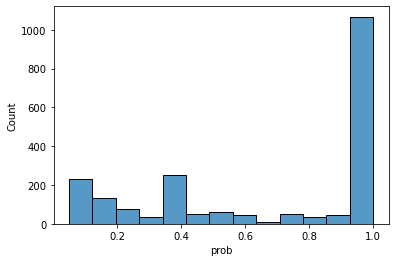

In [49]:
sns.histplot(gwas_hichip.prob)

## Investigate the prioritized SNPs per cell

In [50]:
cell_specific = gwas_hichip_genes.groupby('cline_loop')

In [51]:
gwas_hichip_genes['log10_pval'] = -1 * np.log10(gwas_hichip_genes['pval'])

In [52]:
for cell, cell_df in cell_specific:
    print('***************{}*****************'.format(cell))
    
    tdf = cell_df.sort_values('log10_pval', ascending=False)
    display(tdf[['rsid', 'genename', 'prob', 'log10_pval']])
    
    genelist_fn = os.path.join(outdir, 'genelist.{}.txt'.format(cell))
    tdf.genename.drop_duplicates().to_csv(genelist_fn, header=False, index=False)

***************CD4N*****************


,rsid,genename,prob,log10_pval
36,1:114419368,VANGL1,0.987447,3.394882e+01
504,12:56435412,AC034102.4,0.909011,2.158169e+01
510,12:56435412,TAC3,0.909011,2.158169e+01
509,12:56435412,RF00554,0.909011,2.158169e+01
1063,16:75252103,AC009163.5,0.327679,9.075117e+00
1061,16:75252103,TMEM170A,0.327679,9.075117e+00
1062,16:75252103,CHST6,0.327679,9.075117e+00
70,10:6102757,RF00397,1.000000,8.878480e+00
293,12:9914005,LINC02598,0.394250,8.779339e+00
294,12:9914005,AC022075.1,0.394250,8.779339e+00


***************CD8N*****************


,rsid,genename,prob,log10_pval
1655,22:37581485,CARD10,1.000000,1.304133e+01
1066,16:75252103,TMEM170A,0.327679,9.075117e+00
74,10:6102757,RF00397,1.000000,8.878480e+00
320,12:9914005,LINC02598,0.394250,8.779339e+00
321,12:9914005,AC022075.1,0.394250,8.779339e+00
330,12:9914005,YBX3,0.394250,8.779339e+00
340,12:9914005,RPL13AP20,0.394250,8.779339e+00
1280,2:169046632,AC007556.1,1.000000,8.650442e+00
1285,2:169046585,AC007556.1,0.980843,6.306227e+00
1272,2:169036718,AC007556.1,0.852268,5.407948e+00


***************CM*****************


,rsid,genename,prob,log10_pval
525,12:56435412,AC024884.2,0.909011,2.158169e+01
526,12:56435412,AC024884.1,0.909011,2.158169e+01
1714,11:128604174,ETS1,0.268377,1.023414e+01
1707,11:128604232,ETS1,0.426275,1.014114e+01
1008,16:28505660,AC020765.1,0.564297,8.818037e+00
1010,16:28505660,AC020765.2,0.564297,8.818037e+00
1009,16:28505660,SGF29,0.564297,8.818037e+00
1004,16:28505660,RF00402,0.564297,8.818037e+00
1006,16:28505660,NUPR1,0.564297,8.818037e+00
381,12:9914005,LINC02598,0.394250,8.779339e+00


***************NB*****************


,rsid,genename,prob,log10_pval
519,12:56435412,HSPD1P4,0.909011,2.158169e+01
1001,16:28505660,AC020765.2,0.564297,8.818037e+00
1000,16:28505660,SGF29,0.564297,8.818037e+00
349,12:9914005,KLRF1,0.394250,8.779339e+00
355,12:9914005,RN7SKP161,0.394250,8.779339e+00
364,12:9914005,AC022075.1,0.394250,8.779339e+00
363,12:9914005,LINC02598,0.394250,8.779339e+00
880,14:89771348,RAB42P1,0.974409,8.630890e+00
889,14:89771348,AL137230.2,0.974409,8.630890e+00
890,14:89771348,EFCAB11,0.974409,8.630890e+00


***************NK*****************


,rsid,genename,prob,log10_pval
540,12:56435412,TAC3,0.909011,2.158169e+01
538,12:56435412,RF00554,0.909011,2.158169e+01
1676,1:114420328,VANGL1,1.000000,1.184370e+01
1070,16:75252103,CHST6,0.327679,9.075117e+00
1069,16:75252103,TMEM170A,0.327679,9.075117e+00
1071,16:75252103,AC009163.5,0.327679,9.075117e+00
410,12:9914005,AC068775.1,0.394250,8.779339e+00
450,12:9914005,RPL13AP20,0.394250,8.779339e+00
402,12:9914005,LINC02598,0.394250,8.779339e+00
403,12:9914005,AC022075.1,0.394250,8.779339e+00


In [53]:
genelist_fn = os.path.join(outdir, 'genelist.all.txt')
gwas_hichip_genes.genename.drop_duplicates().to_csv(genelist_fn, header=False, index=False)

## Making an upset plot of SGL genes

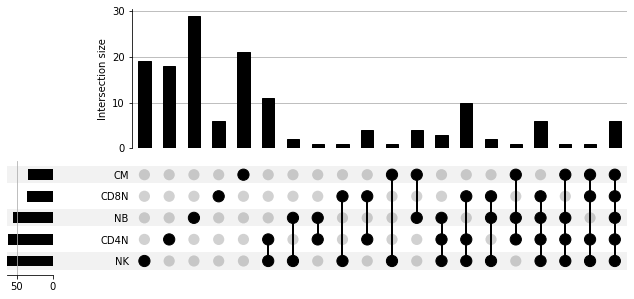

In [54]:
cline_sgenes = gwas_hichip_genes.groupby('cline_loop').genename.unique().to_dict()

# making the upset input dataframe
upset_input = upsetplot.from_contents(cline_sgenes)

# plotting the upset plot
plot = upsetplot.UpSet(upset_input, subset_size='count').plot()

In [55]:
upset_input.loc[(True, True, True, True)]

/mnt/hpcscratch/jreyna//ipykernel_48643/3253413360.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  upset_input.loc[(True, True, True, True)]


,id
NK,
True,LINC02598
True,AC022075.1
True,MAPKAPK5
True,MAPKAPK5-AS1
True,RNU6-921P
True,TYK2


## Characterizing SNPs within an SGL using ChromHMM annotations

In [56]:
#loading Vu et al 2022 chromHMM annotations 
chromhmm = pd.read_table('results/refs/chromHMM/vu_et_al_2022/hg38lift_genome_100_segments.bed.gz', 
                         header=None)
chromhmm_pbt = pbt.BedTool.from_dataframe(chromhmm)

In [57]:
finemapping_pbt = gwas_hichip_genes[['chr_snp', 'pos', 'pos']].drop_duplicates()
finemapping_pbt.iloc[:, 0] = 'chr' + finemapping_pbt.iloc[:, 0].astype(str)
finemapping_pbt.iloc[:, 1] = finemapping_pbt.iloc[:, 1] - 1 # convert to bed format 
finemapping_pbt = pbt.BedTool.from_dataframe(finemapping_pbt)

In [66]:
gwas_hichip_genes[['chr_snp', 'pos', 'pos']].drop_duplicates().shape

(93, 3)

In [58]:
finemapping_chromhmm = finemapping_pbt.intersect(chromhmm_pbt, loj=True, wa=True)
finemapping_chromhmm = finemapping_chromhmm.to_dataframe()
finemapping_chromhmm.columns = ['chr', 'start', 'end', 'chr2', 'chmm_start', 'chmm_end', 'state']

# extract the statename without the id number
def split_chromhmm(x):
    s = x.split('_')
    if len(s) > 1:
        return(s[1])
    else:
        return('None')
finemapping_chromhmm['state_name'] = finemapping_chromhmm.state.map(split_chromhmm)

# add the major state which removes the subtypes
finemapping_chromhmm['major_state'] = finemapping_chromhmm.state_name.str.replace('[0-9]+', '')

/mnt/hpcscratch/jreyna//ipykernel_48643/3274623952.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  finemapping_chromhmm['major_state'] = finemapping_chromhmm.state_name.str.replace('[0-9]+', '')


In [59]:
state_dict = {'Quies': 'Quiescent',
             'ReprPC': 'Repressor',
             'GapArtf': 'No signal, unmappable',
             'Acet': 'Acetylation',
             'TxWk': 'Weak transcription',
             'EnhWk': 'Weak enhancer',
             'None': 'No overlap',
             'Tx': 'Transcription',
             'EnhA': 'Enhancer',
             'TxEx': 'Transcription & Exons',
             'HET': 'H3K9me3 & LTR repeats',
             'TxEnh': 'Transcription & Enhancers',
             'BivProm': 'Bivalent Promoters',
             'znf': 'Zinc Finger',
             'PromF': 'Downstream Promoter',
             'DNase': 'DNase',
             'TSS': 'TSS'}

state_colors = {'Quies': 'grey',
             'ReprPC': 'grey',
             'GapArtf': 'grey',
             'Acet': 'grey',
             'None': 'grey',
             'HET': 'grey',
             'EnhWk': 'lightYellow',
             'EnhA': 'yellow',
             'TxWk': 'lightGreen',
             'Tx': 'darkgreen',
             'TxEx': 'darkgreen',
             'TxEnh': 'darkgreen',
             'DNase': 'blue',
             'znf': 'blue', 
             'BivProm': 'red',
             'PromF': 'red',
             'TSS': 'red'}

fm_state_cnts = finemapping_chromhmm.major_state.value_counts()
fm_state_cnts = fm_state_cnts.to_frame()

In [60]:
fm_state_cnts.columns = ['counts']
fm_state_cnts['major_state'] = fm_state_cnts.index

In [61]:
fm_state_cnts

,counts,major_state
EnhA,20,EnhA
Quies,17,Quies
Tx,12,Tx
ReprPC,11,ReprPC
EnhWk,7,EnhWk
TxEx,6,TxEx
TxWk,5,TxWk
TxEnh,3,TxEnh
HET,3,HET
None,2,None


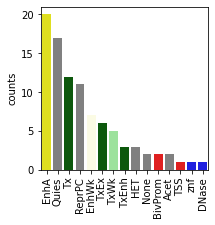

In [72]:
# Ploting the distribution of ALL Fine-mapped SNPs
fig, ax = plt.subplots(figsize=(3,3))

sns.barplot(x='major_state', y='counts', data=fm_state_cnts, hue='major_state', palette=state_colors, dodge=False)

ax.set_xlabel('');
ax.set_xticklabels(fm_state_cnts['major_state'], rotation = 90);

# ax.legend(loc='upper center', bbox_to_anchor=(0.77, 1),
#           fancybox=True, shadow=False)
ax.legend_.set_visible(False)

chromhmm_summary_fn = os.path.join(outdir, 'sgl_finemapped_snps_characterized_chromhmm.svg')
fig.savefig(chromhmm_summary_fn)

chromhmm_summary_fn = os.path.join(outdir, 'sgl_finemapped_snps_characterized_chromhmm.png')
fig.savefig(chromhmm_summary_fn)

In [63]:
gwas_hichip_genes[['chr_snp', 'pos', 'gwas_source']].drop_duplicates().sort_values(by=['gwas_source', 'chr_snp', 'pos'])

,chr_snp,pos,gwas_source
2115,1,36365089,T1D_32005708
36,1,114419368,T1D_32005708
1243,2,166810624,T1D_32005708
2135,2,169002579,T1D_32005708
1272,2,169036718,T1D_32005708
1274,2,169040419,T1D_32005708
1284,2,169046585,T1D_32005708
1279,2,169046632,T1D_32005708
2138,2,169062982,T1D_32005708
1414,5,39211189,T1D_32005708


In [64]:
gwas_hichip_genes.loc[gwas_hichip_genes.gwas_source == 'T1D_32005708'].\
                        sort_values(by=['chr_snp', 'pos'])

,chr_snp,bin_start_x,bin_end_x,pos,chrA_loop,startA_loop,endA_loop,chrB_loop,startB_loop,endB_loop,cline_loop,gwas_source,regionID,GWASLoci,index,rsid,chromosome,position,allele1,allele2,maf,beta,se,z,prob,log10bf,mean,sd,mean_incl,sd_incl,pval,bin_start_y,bin_end_y,sid,loop_id,snp_anchor,gh_id,chrSNP,startSNP,endSNP,chrGene,startGene,endGene,genename,geneid,strand,bin_start,bin_end,log10_pval
2115,1,36365000,36370000,36365089,1,36365000,36370000,1,36395000,36400000,NK,T1D_32005708,2,chr1:35880971-36880971,1393,1:36365089,1,36365089,A,G,0.0046,0.7052,0.1895,3.72137,0.079382,1.93803,0.023371,0.106908,0.294407,0.253344,9.907164e-05,36365000,36370000,chr1:36365089,36370000:36365089:1:36365000:36370000:1,AnchorA,2060,1.0,36395000.0,36400000.0,1.0,36397907.0,36397908.0,LSM10,ENSG00000181817,-,36395000.0,36400000.0,4.004051
36,1,114415000,114420000,114419368,1,114415000,114420000,1,115640000,115645000,CD4N,T1D_32005708,6,chr1:113319380-115064892,3023,1:114419368,1,114419368,T,A,0.2156,0.3350,0.0274,12.22630,0.987447,5.32338,-0.559377,0.082714,-0.566488,0.053853,1.125083e-34,114415000,114420000,chr1:114419368,114420000:114419368:1:114415000:114420000:1,AnchorA,36,1.0,115640000.0,115645000.0,1.0,115641969.0,115641970.0,VANGL1,ENSG00000173218,+,115640000.0,115645000.0,33.948816
1243,2,166810000,166815000,166810624,2,166145000,166150000,2,166810000,166815000,CD4N,T1D_32005708,68,chr2:166400130-167400130,1669,2:166810624,2,166810624,C,T,0.0546,-0.2124,0.0556,-3.82014,0.059365,2.05723,-0.015111,0.063462,-0.254550,0.083017,9.999333e-01,166810000,166815000,chr2:166810624,166815000:166810624:2:166145000:166150000:2,AnchorB,1199,2.0,166145000.0,166150000.0,2.0,166149213.0,166149214.0,SCN1A,ENSG00000144285,-,166145000.0,166150000.0,0.000029
1247,2,166810000,166815000,166810624,2,166180000,166185000,2,166810000,166815000,CD4N,T1D_32005708,68,chr2:166400130-167400130,1669,2:166810624,2,166810624,C,T,0.0546,-0.2124,0.0556,-3.82014,0.059365,2.05723,-0.015111,0.063462,-0.254550,0.083017,9.999333e-01,166810000,166815000,chr2:166810624,166815000:166810624:2:166180000:166185000:2,AnchorB,1203,2.0,166180000.0,166185000.0,2.0,166180965.0,166180966.0,RN7SKP152,ENSG00000222376,-,166180000.0,166185000.0,0.000029
1251,2,166810000,166815000,166810624,2,165835000,165840000,2,166810000,166815000,CD8N,T1D_32005708,68,chr2:166400130-167400130,1669,2:166810624,2,166810624,C,T,0.0546,-0.2124,0.0556,-3.82014,0.059365,2.05723,-0.015111,0.063462,-0.254550,0.083017,9.999333e-01,166810000,166815000,chr2:166810624,166815000:166810624:2:165835000:165840000:2,AnchorB,1207,2.0,165835000.0,165840000.0,2.0,165839097.0,165839098.0,AC009495.2,ENSG00000232411,-,165835000.0,165840000.0,0.000029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1132,19,10590000,10595000,10594558,19,10380000,10385000,19,10590000,10595000,CM,T1D_32005708,57,chr19:9963118-10963118,1637,19:10594558,19,10594558,C,G,0.0786,-0.0561,0.0482,-1.16390,0.997334,5.84253,-0.032957,0.598881,-0.033045,0.599679,8.777678e-01,10590000,10595000,chr19:10594558,10595000:10594558:19:10380000:10385000:19,AnchorB,1090,19.0,10380000.0,10385000.0,19.0,10380675.0,10380676.0,TYK2,ENSG00000105397,-,10380000.0,10385000.0,0.056620
1178,19,58085000,58090000,58087868,19,58085000,58090000,19,58510000,58515000,CD4N,T1D_32005708,59,chr19:57594306-58594306,2827,19:58087868,19,58087868,T,C,0.0115,0.4987,0.1124,4.43683,0.549215,3.37565,0.123006,0.274490,0.223968,0.338489,4.564609e-06,58085000,58090000,chr19:58087868,58090000:58087868:19:58085000:58090000:19,AnchorA,1134,19.0,58510000.0,58515000.0,19.0,58512412.0,58512413.0,SLC27A5,ENSG00000083807,-,58510000.0,58515000.0,5.340596
1189,19,58085000,58090000,58087868,19,58085000,58090000,19,58220000,58225000,NB,T1D_32005708,59,chr19:57594306-58594306,2827,19:58087868,19,58087868,T,C,0.0115,0.4987,0.1124,4.43683,0.549215,3.37565,0.123006,0.274